In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def read_image(img_path):
    image = cv2.imread(img_path)
    (H, W) = image.shape[:2]
    return image, H, W
def build_net(image, configPath, weightsPath):
    net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
    ln = net.getLayerNames()
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
                                 swapRB=True, crop=False)
    net.setInput(blob)
    return net.forward(ln)
def predict_and_draw(image_path, 
                     configPath, weightsPath, 
                     confidence_min, thresholds_min,
                     COLORS, LABELS):
    image, H, W = read_image(image_path)
    layerOutputs = build_net(image=image, configPath=configPath, weightsPath=weightsPath)
    print(f"Lenght Outputs: {len(layerOutputs)}")
    boxes = []
    confidences = []
    classIDs = []
    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > confidence_min:
                box = detection[:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence_min, thresholds_min)
    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            color = [int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
    			1, (255,255,255), 2)
        return image, text
    else:
        return image, ''


In [14]:
weightsPath = "./models/yolov3-spp.weights"
configPath = "./models/yolov3-spp.cfg"
# img_path = "./dataset/fungi/val/11325_Cantharellus_pallens/MC2017-9204266_SkcMQ5rOZ.JPG"
img_path = "/home/sergio/Изображения/photo1680001310.jpeg"
confidence_min = 0.1
thresholds_min = 0.1
# load our YOLO object detector trained on COCO dataset (80 classes)
LABELS = open("./my_utils/coco.names").read().strip().split("\n")
print(len(LABELS))
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

print("[INFO] loading YOLO from disk...")


80
[INFO] loading YOLO from disk...


Lenght Outputs: 3


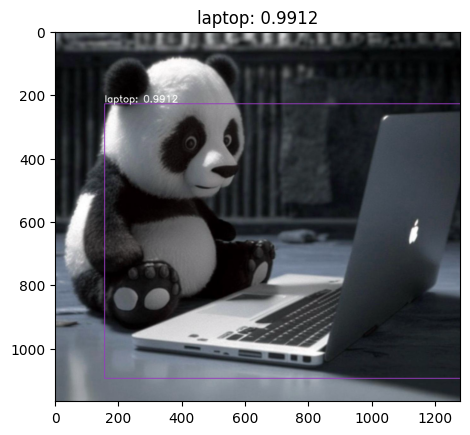

In [13]:
image, text = predict_and_draw(
    image_path=img_path,
    configPath=configPath,
    weightsPath=weightsPath,
    confidence_min=confidence_min,
    thresholds_min=thresholds_min,
    COLORS=COLORS, LABELS=LABELS
)
plt.title(text)
plt.imshow(image);

In [97]:
import torch
model = torch.hub.load(
    'ultralytics/yolov5', 
    'yolov5n', 
    # 'yolov5s', 
    # 'yolov5m', 
    # 'yolov5l', 
    # 'yolov5x', 
    # 'yolov5n6', 
    # 'yolov5s6', 
    # 'yolov5m6', 
    # 'yolov5l6', 
    # 'yolov5x6', 
    pretrained=True,
    channels=3,
    classes=80,
    _verbose=False,
    )
# model_v5x6 = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
# model_v5n = torch.hub.load('ultralytics/yolov5', 'yolov5n', pretrained=True)
# imgs = ['https://ultralytics.com/images/zidane.jpg']  # batch of images
model.conf = 0.15  # NMS confidence threshold
model.iou = 0.05  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = True  # NMS multiple labels per box
model.classes = None  # (optional list) filter by class, i.e. = [0, 15, 16] for COCO persons, cats and dogs
model.max_det = 100  # maximum number of detections per image
model.amp = False  # Automatic Mixed Precision (AMP) inference

Using cache found in /home/sergio/.cache/torch/hub/ultralytics_yolov5_master


image 1/1: 1734x1734 1 person
Speed: 76.4ms pre-process, 14.9ms inference, 3.6ms NMS per image at shape (1, 3, 320, 320)


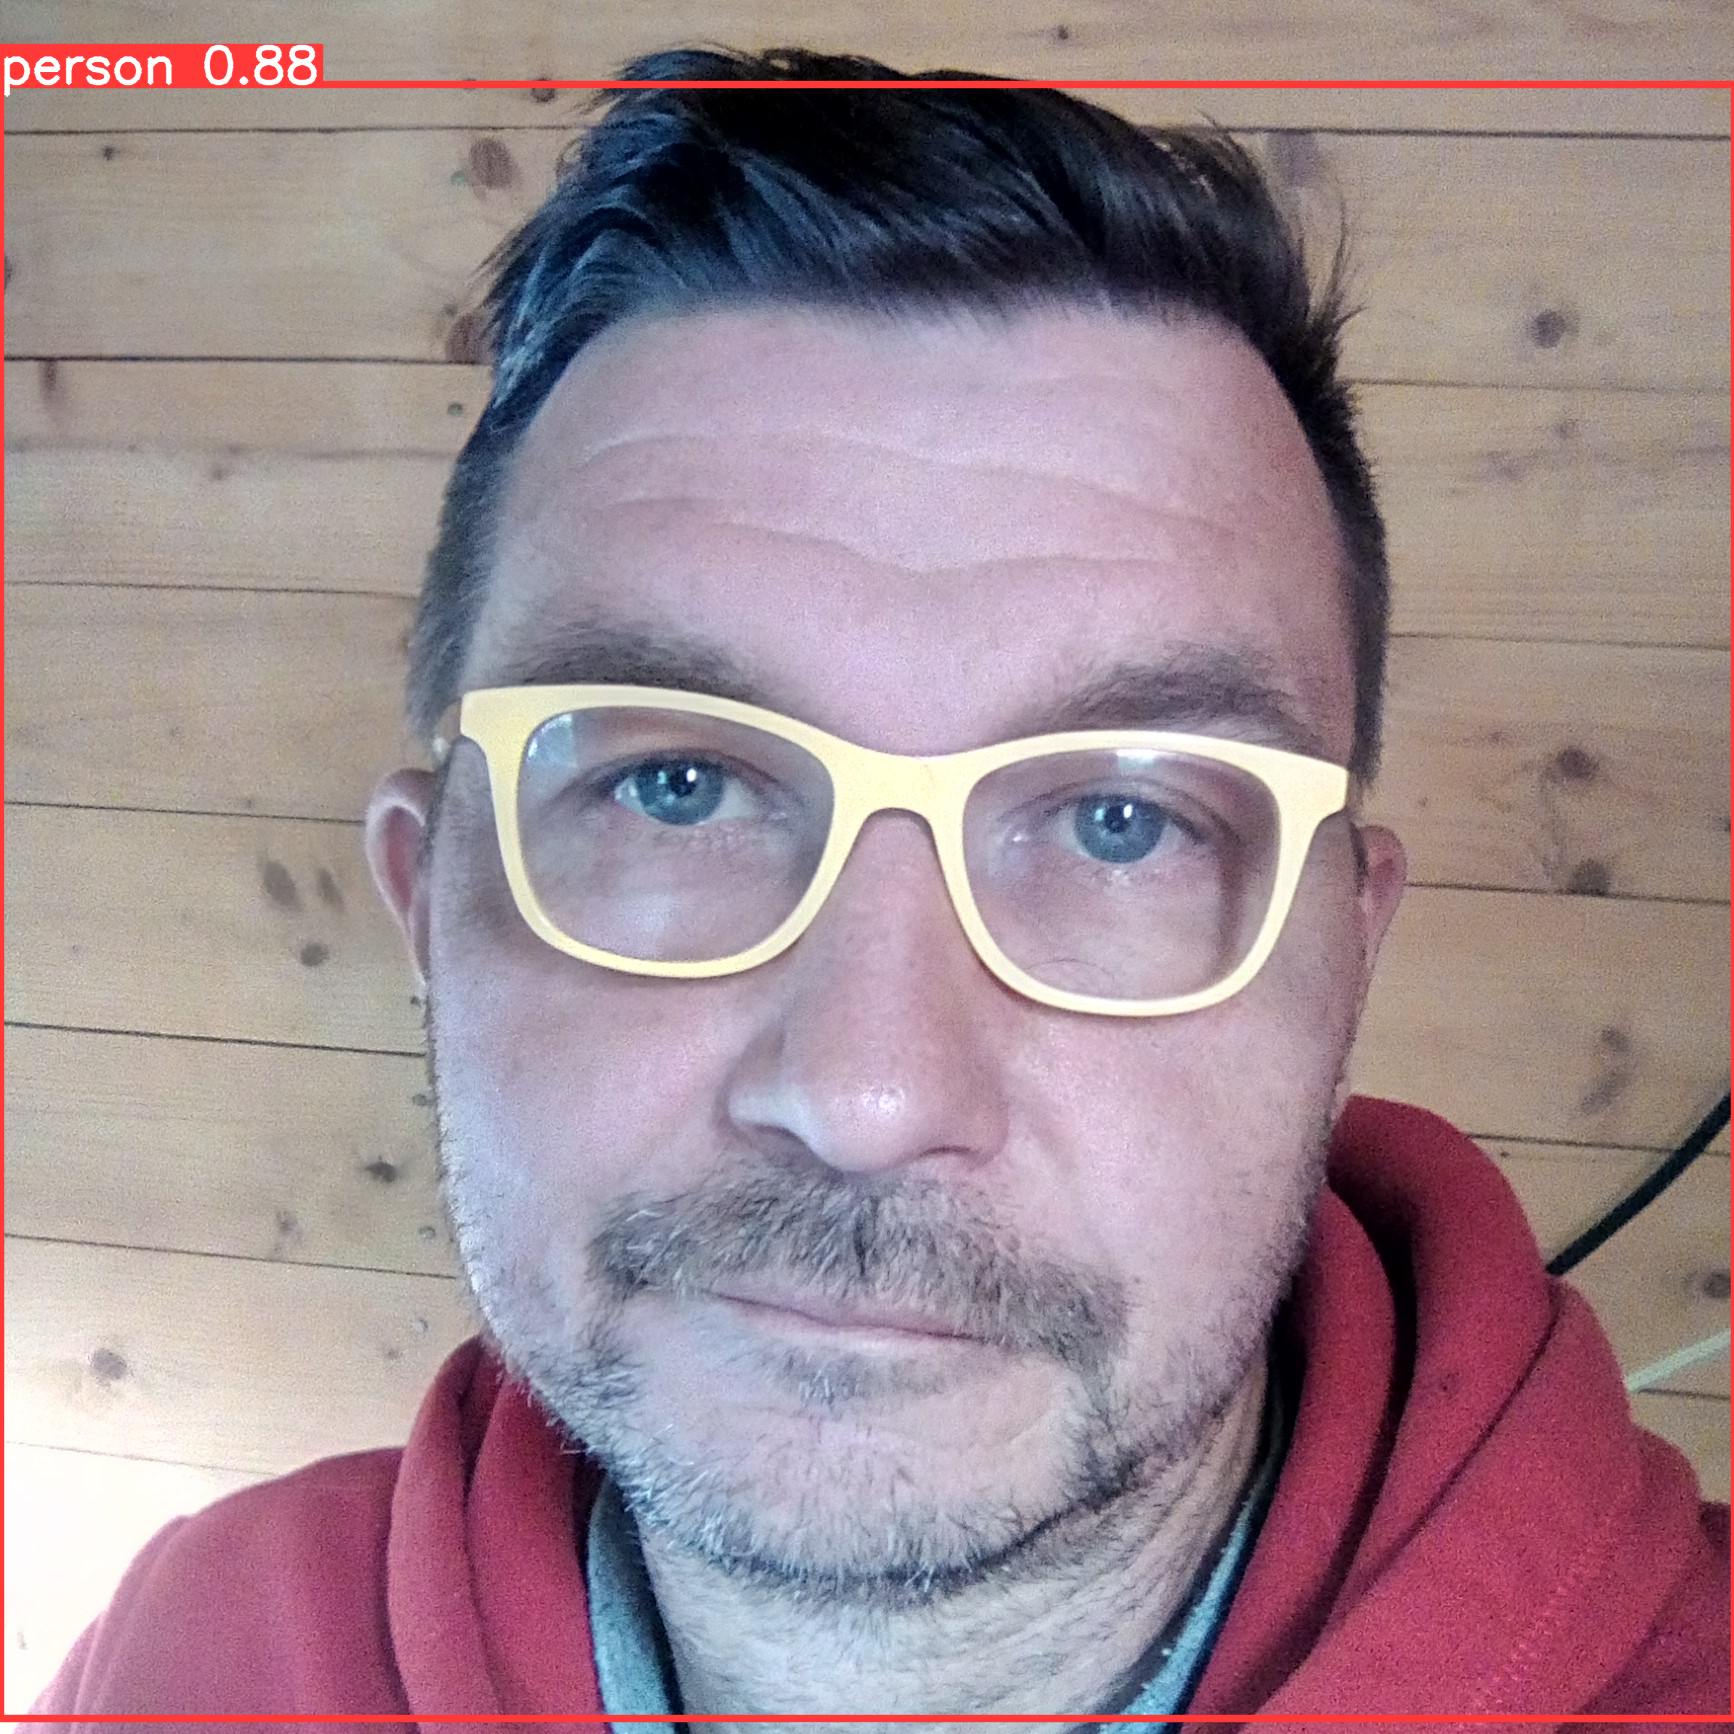

In [100]:
# img_path = "./dataset/fungi/val/11325_Cantharellus_pallens/MC2017-9204266_SkcMQ5rOZ.JPG"
# img_path = "/home/sergio/Изображения/photo1680001310.jpeg"
img_path = "/home/sergio/Документы/DOCS/DOCS/face/CV_foto_Sergey_quad.jpg"
imgs = [img_path]
results = model(imgs, size=320)
# results = model_v5x6(imgs)
# results = model_v5n(imgs)
plt.rcParams['figure.figsize'] = (3,3)
results.print()
# results.save()  # or .show() .save()
results.show()  # or .show() .save()

In [99]:
results.xyxy[0]  # img1 predictions (tensor)
results.pandas().xyxy[0]

xmin       ymin    xmax         ymax  confidence  class    name
0   0.0  84.955963  1734.0  1718.819702    0.882636      0  person